In [1]:
import importlib
import xarray as xr
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

from ecpaper_utils import jlat_utils as jlat
from ecpaper_utils import bootstrap_utils as boot

importlib.reload(jlat)
importlib.reload(boot)

import warnings
warnings.filterwarnings('ignore')

Read in MMLEA data

In [3]:
modnames=['CanESM2','CESM1-CAM5','CSIRO-Mk3-6-0','GFDL-CM3','MPI-ESM']
datadir="/project/cas/islas/python_savs/ecpaper2020/DATASORT/SHJET/"

generate histograms and bootstrapping estimates of the standard deviations for each MMLEA model

In [4]:
datadict={}
binsp=np.arange(-2,2.1,0.1)
binsdif=np.arange(-3,3.1,0.1)

histopast = np.zeros([np.size(binsp)-1,len(modnames)])
histodif = np.zeros([np.size(binsdif)-1, len(modnames)])
stdev_phip = np.zeros([len(modnames)])
stdev_phidif = np.zeros([len(modnames)])
mincistdev = np.zeros([len(modnames)])
maxcistdev = np.zeros([len(modnames)])
mincistdevboot = np.zeros([len(modnames)])
maxcistdevboot = np.zeros([len(modnames)])
phippooled = []


for imod in range(len(modnames)):
    print(modnames[imod])
    datapast = xr.open_dataset(datadir+'uzmpast_'+modnames[imod]+'.nc')
    datafut = xr.open_dataset(datadir+'uzmfut_'+modnames[imod]+'.nc')
    phip=np.zeros(datapast.member.size)
    phif=np.zeros(datapast.member.size)
    phip_em, phispeed = jlat.calcjetlat(datapast.upast_jja_zm.mean(dim='member'), -80, -20)
    phif_em, phispeed = jlat.calcjetlat(datafut.ufut_jja_zm.mean(dim='member'), -80, -20)
    bootstdevs = np.zeros([datapast.member.size])
    for imem in range(0,datapast.member.size,1):
        phip[imem], phispeed = jlat.calcjetlat(datapast.upast_jja_zm.isel(member=imem), -80., -20.)
        phif[imem], phispeed = jlat.calcjetlat(datafut.ufut_jja_zm.isel(member=imem), -80., -20.)

        #estimate the standard deviation for each member by bootstrapping over years
        bootdat =boot.bootgen_multimem(xr.DataArray(datapast.upast_jja_ts_zm.isel(member=imem)), datapast.time.size)
        jlatboot=np.zeros([1000])
        for iboot in range(0,1000,1):
            jlatboot[iboot], jspeed = jlat.calcjetlat(bootdat[iboot,:], -80, -20)            
        bootstdevs[imem] = np.std(jlatboot)  
 
    mincistdevboot[imod] = np.min(bootstdevs)
    maxcistdevboot[imod] = np.max(bootstdevs)

    phip = phip - phip_em
    phif = phif - phif_em
    phippooled.extend(phip)
    
    histopast[:,imod], binedgesp = np.histogram(phip, bins=binsp)
    histopast[:,imod] = (histopast[:,imod]/np.size(phip))*100.
    histodif[:,imod], binedgesdif = np.histogram(phif-phip, bins=binsdif)
    histodif[:,imod] = (histodif[:,imod]/np.size(phip))*100.
    
    stdev_phip[imod] = np.std(phip)
    stdev_phidif[imod] = np.std(phif-phip)
    
    mincistdev[imod], maxcistdev[imod] = boot.boot_stdev_ci(phip,95)
    
phippoolednp = np.array(phippooled)
stdevphippooled = np.std(phippoolednp)

CanESM2
CESM1-CAM5
CSIRO-Mk3-6-0
GFDL-CM3
MPI-ESM


Generate bootstrapping estimates of the standard deviation for the reanalyses.

In [5]:
obsname=['ERA5','ERAI','JRA','MERRA2']
obsnamelong=['ERA5','ERA-Interim','JRA55','MERRA2']
obsstd=np.zeros([len(obsname)])
for iobs in range(0,len(obsname)):
    print(obsname[iobs])
    data = xr.open_dataset(datadir+"uzm_"+obsname[iobs]+".nc")
    bootdat = boot.bootgen_multimem(xr.DataArray(data.ujja), data.time.size)
    jlatboot=np.zeros([1000])
    for iboot in range(0,1000,1):
        jlatboot[iboot], jspeed = jlat.calcjetlat(bootdat[iboot,:], -80, -20)
        
    obsstd[iobs] = np.std(jlatboot)

ERA5
ERAI
JRA
MERRA2


CMIP6 versus CMIP5 figure

In [6]:
cmip5models = ['ACCESS1-3', 'bcc-csm1-1-m','CanESM2','CESM1-CAM5','CESM1-WACCM','CMCC-CMS','CNRM-CM5','EC-EARTH','FGOALS-g2','FIO-ESM','GFDL-CM3','GFDL-ESM2M','GISS-E2-R',
              'HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC5','MIROC-ESM','MPI-ESM-LR','MPI-ESM-MR','MRI-CGCM3','NorESM1-ME']
cmip6models = ['ACCESS-CM2', 'BCC-CSM2-MR','CanESM5','CESM2','CESM2-WACCM','CMCC-CM2-SR5','CNRM-CM6-1','EC-Earth3','FGOALS-g3','FIO-ESM-2-0','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G',
              'HadGEM3-GC31-LL','INM-CM5-0','IPSL-CM6A-LR','MIROC6','MIROC-ES2L','MPI-ESM1-2-LR','MPI-ESM1-2-HR','MRI-ESM2-0','NorESM2-LM']

cmip5dat = xr.open_dataset(datadir+'jlatcmip5.nc')
cmip6dat = xr.open_dataset(datadir+'jlatcmip6.nc')

jlatcmip5=np.zeros([len(cmip5models)]) ; jlatcmip6=np.zeros([len(cmip6models)])
for imod in range(0,len(cmip5models),1):
    jlatcmip5[imod] = cmip5dat.jlatemf.sel(model=cmip5models[imod]) - cmip5dat.jlatemp.sel(model=cmip5models[imod])
    
for imod in range(0,len(cmip6models),1):
    jlatcmip6[imod] = cmip6dat.jlatemf.sel(model=cmip6models[imod]) - cmip6dat.jlatemp.sel(model=cmip6models[imod])


CMIP6 versus CMIP5 plot

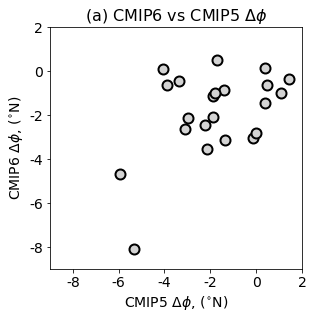

In [7]:
fig = plt.figure()
w = 7 ; h =24
fig.set_size_inches(w,h)
ax1 = fig.add_axes(np.array([0.05,0.83,0.5,0.14]))

ax1.set_xlim(-9,2)
ax1.set_ylim(-9,2)
ax1.set_xticks([-8,-6,-4,-2,0,2])
ax1.set_xticklabels(['-8','-6','-4','-2','0','2'], fontsize=14)
ax1.set_yticks([-8,-6,-4,-2,0,2])
ax1.set_yticklabels(['-8','-6','-4','-2','0','2'], fontsize=14)
ax1.set_xlabel('CMIP5 $\Delta \phi$, ($^{\circ}$N)', fontsize=14)
ax1.set_ylabel('CMIP6 $\Delta \phi$, ($^{\circ}$N)', fontsize=14)
ax1.set_title('(a) CMIP6 vs CMIP5 $\Delta \phi$', fontsize=16)

ax1.plot(jlatcmip5,jlatcmip6,"o", markersize=10, markerfacecolor='lightgray', markeredgecolor='black', markeredgewidth=2)

In [8]:
ax2 = fig.add_axes(np.array([0.65,0.83,0.17,0.14]))

corval = np.corrcoef(jlatcmip5,jlatcmip6)
corval = corval[0,1]
mincor, maxcor = boot.boot_corr_ci(jlatcmip5,jlatcmip6,95)

ax2.set_xlim(0,2)
ax2.set_ylim(-0.5,1)
ax2.set_xticks([])
ax2.set_yticks([-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels(['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)
#ax2.label_params(axis='y',pad=0)
ax2.set_ylabel("Correlation", fontsize=14, labelpad=-1)
ax2.set_title('(b) Cor(5,6)', fontsize=16)


ax2.bar(1,corval,color='lightgray', edgecolor='black')
ax2.plot([0,2],[0,0], color='black')
ax2.errorbar(1, corval, [[corval-mincor],[maxcor-corval]], color='black', linewidth=2, capsize=5, capthick=2)

#axs.set_yticklabels(['-0.4','-0.2','0','0.2','0.4','0.6','0.8','1'], fontsize=14)

<ErrorbarContainer object of 3 artists>

Past jet latitude histograms

In [9]:
ax3 = fig.add_axes(np.array([0.05,0.59,0.35,0.2]))

lecolor=['mediumseagreen','mediumpurple','dodgerblue','orangered','mediumvioletred']

dely=18 

ax3.set_xlim(-2,2)
ax3.set_ylim(0,dely*5)

yticks=[8, 16, dely+8, dely+16, 2*dely+8, 2*dely+16, 3*dely+8, 3*dely+16, 4*dely+8, 4*dely+16 ]
yticknames=['8','16','8','16','8','16','8','16','8','16']
xticks=[-2,-1,0,1,2]
xticknames=['-2','-1','0','1','2']

ax3.set_yticks(yticks)
ax3.set_yticklabels(yticknames, fontsize=14)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xticknames, fontsize=14)
ax3.set_xlabel('$\phi_{o}$ ($\circ N$)', fontsize=14)
ax3.set_ylabel('% of samples', fontsize=14)
ax3.set_title('(c) LE, $\phi_{o}$', fontsize=16)

for imod in range(len(modnames)):
    ax3.bar(binedgesp[0:np.size(binedgesp)-1], histopast[:,imod], width=binedgesp[1]-binedgesp[0], bottom=(4-imod)*dely, edgecolor='black', color=lecolor[imod])
    string = '{0:6.2f}'.format(stdev_phip[imod]).strip()
    ax3.text(-1.9,(4-imod)*dely + 14,'$\sigma(\phi_{o})$='+string, fontsize=12)

Jet shift histograms

In [10]:
ax4 = fig.add_axes(np.array([0.47,0.59,0.35,0.2]))

dely=18 

ax4.set_xlim(-3,3)
ax4.set_ylim(0,dely*5)

yticks=[8, 16, dely+8, dely+16, 2*dely+8, 2*dely+16, 3*dely+8, 3*dely+16, 4*dely+8, 4*dely+16 ]
yticknames=['8','16','8','16','8','16','8','16','8','16']
xticks=[-2,-1,0,1,2]
xticknames=['-2','-1','0','1','2']

ax4.set_yticks(yticks)
ax4.set_yticklabels(yticknames, fontsize=14)
ax4.set_xticks(xticks)
ax4.set_xticklabels(xticknames, fontsize=14)
ax4.set_xlabel('$\Delta \phi$ ($\circ N$)', fontsize=14)
ax4.set_ylabel(' ', fontsize=14)
ax4.set_title('(d) LE, $\Delta \phi$', fontsize=16)

for imod in range(len(modnames)):
    ax4.bar(binedgesdif[0:np.size(binedgesdif)-1], histodif[:,imod], width=binedgesdif[1]-binedgesdif[0], bottom=(4-imod)*dely, edgecolor='black', color=lecolor[imod])
    string = '{0:6.2f}'.format(stdev_phidif[imod]).strip()
    ax4.text(-2.85,(4-imod)*dely + 14,'$\sigma(\Delta \phi)$='+string, fontsize=12)

In [11]:
ax5 = fig.add_axes(np.array([0.05,0.47,0.77,0.08]))


ax5.set_ylim(0,1.5)
ax5.set_xlim(-0.5,19)

ax5.set_xticks([1,4,7,10,13, 15, 16, 17, 18])
ax5.set_xticklabels(modnames+obsnamelong, rotation=40, fontsize=14, ha='right')
ax5.set_yticks([0,0.5,1,1.5])
ax5.set_yticklabels(['0','0.5','1','1.5'], fontsize=14)
ax5.set_ylabel('$\sigma(\phi_{o})$, $(^{\circ}$)', fontsize=14)
ax5.set_title('(e) $\sigma(\phi_{o})$', fontsize=16)

colors=lecolor+["black","black","black","black"]

for color, tick in zip(colors, ax5.xaxis.get_major_ticks()):
    tick.label1.set_color(color)

errordat = xr.open_dataset('../ERRORCALC/JLAT/DATA/errors_1mem.nc')
#ax5.plot([-0.5,19],[stdevphippooled,stdevphippooled],linestyle='dotted', linewidth=3, color='black')
ax5.plot([-0.5,19], [errordat['sigx_1mem'],errordat['sigx_1mem']], linestyle='dotted', linewidth=3, color='black')

for imod in range(len(modnames)):
    ax5.bar(imod*3+1,stdev_phip[imod], width=1, bottom=0, edgecolor='black', color=lecolor[imod])
    ax5.errorbar(imod*3+1,stdev_phip[imod],[[stdev_phip[imod] - mincistdev[imod]], [maxcistdev[imod]-stdev_phip[imod]]], linewidth=2, capsize=5, capthick=2, color='black')
    ax5.errorbar(imod*3+1.9,stdev_phip[imod], [[stdev_phip[imod] - mincistdevboot[imod]],[maxcistdevboot[imod]-stdev_phip[imod]]],linewidth=2,capsize=5,capthick=2,color=lecolor[imod])
    
for iobs in range(len(obsname)):
    ax5.plot(15+iobs,obsstd[iobs],marker='o', color='black', markersize=12)

In [12]:
fig.savefig('fig4.pdf', facecolor='white', bbox_inches='tight')